In [27]:
import pandas as pd
import os
import sys
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import shutil
from osgeo import ogr
from collections import OrderedDict

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws, delete_items
from scripts.utils.cal_crai_calculations import calculate_equal_weighted_index, add_census_tracts
from scripts.utils.cal_crai_plotting import index_plot, plot_region_domain, plot_hazard_score

In [2]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/calcrai_score'
output_folder = 'cal_crai_score_file'

pull_csv_from_directory(bucket_name, aws_dir, output_folder, search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/calcrai_score.


In [10]:
calcrai_score = pd.read_csv(r'cal_crai_score_file/calcrai_score.csv')

In [12]:
keep_columns = ['GEOID', 'hazard_score', 'calcrai_score']
calcrai_plotting_columns = calcrai_score[keep_columns]

# Ensure all values in GEOID are strings
calcrai_plotting_columns['GEOID'] = calcrai_plotting_columns['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
calcrai_plotting_columns['GEOID'] = calcrai_plotting_columns['GEOID'].str.zfill(calcrai_plotting_columns['GEOID'].str.len().max() + 1)

# Display the dataframe
calcrai_plotting_columns

calcrai_plotting_columns

C:\Users\jesse\AppData\Local\Temp\ipykernel_19596\1058555045.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calcrai_plotting_columns['GEOID'] = calcrai_plotting_columns['GEOID'].astype(str)
C:\Users\jesse\AppData\Local\Temp\ipykernel_19596\1058555045.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calcrai_plotting_columns['GEOID'] = calcrai_plotting_columns['GEOID'].str.zfill(calcrai_plotting_columns['GEOID'].str.len().max() + 1)


,GEOID,hazard_score,calcrai_score
0,06001400100,0.691840,0.593840
1,06001400200,0.643412,0.520210
2,06001400300,0.701468,0.384277
3,06001400400,0.643200,0.417900
4,06001400500,0.715325,0.350419
...,...,...,...
9124,06115040902,0.315723,1.320288
9125,06115041001,0.294586,1.037047
9126,06115041002,0.305539,1.342894
9127,06115041101,0.278509,1.337257


In [13]:
# Binning into quartiles
binned_equal_df = calcrai_plotting_columns.copy()

# Define the columns to bin
columns_to_bin = [
    'calcrai_score'
]

# Apply qcut to each specified column and print the bin edges
for column in columns_to_bin:
    # Get the bin labels and edges
    binned_equal_df[column + '_quartile'], bin_edges = pd.qcut(
        binned_equal_df[column], 
        q=[0,0.2, 0.4, 0.6, 0.8, 1.0], 
        labels=False,
        # labels=['<20%', '20-40%', '40-60%', '60-80%', '>80%'],
        duplicates='drop', 
        retbins=True
    )
    print(f'Bin edges for {column}: {bin_edges}')

# Show the resulting DataFrame with the binned columns
binned_equal_df = binned_equal_df[['GEOID','calcrai_score_quartile']]
binned_equal_df

Bin edges for calcrai_score: [0.         0.50782468 0.68969808 1.17630724 1.82769235 4.98642604]


,GEOID,calcrai_score_quartile
0,06001400100,1
1,06001400200,1
2,06001400300,0
3,06001400400,0
4,06001400500,0
...,...,...
9124,06115040902,3
9125,06115041001,2
9126,06115041002,3
9127,06115041101,3


In [14]:
# Create a copy and chain the .replace() calls
binned_df_viz = binned_equal_df.copy()
binned_df_viz['calcrai_score_quartile'] = (
    binned_df_viz['calcrai_score_quartile']
    .replace(0, '0-20%')
    .replace(1, '20-40%')
    .replace(2, '40-60%')
    .replace(3, '60-80%')
    .replace(4, '80+%')
)
binned_df_viz.head()

,GEOID,calcrai_score_quartile
0,06001400100,20-40%
1,06001400200,20-40%
2,06001400300,0-20%
3,06001400400,0-20%
4,06001400500,0-20%


In [16]:
merged_df = pd.merge(calcrai_plotting_columns, binned_df_viz, on='GEOID', how='left')
merged_df

,GEOID,hazard_score,calcrai_score,calcrai_score_quartile
0,06001400100,0.691840,0.593840,20-40%
1,06001400200,0.643412,0.520210,20-40%
2,06001400300,0.701468,0.384277,0-20%
3,06001400400,0.643200,0.417900,0-20%
4,06001400500,0.715325,0.350419,0-20%
...,...,...,...,...
9124,06115040902,0.315723,1.320288,60-80%
9125,06115041001,0.294586,1.037047,40-60%
9126,06115041002,0.305539,1.342894,60-80%
9127,06115041101,0.278509,1.337257,60-80%


In [25]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from shapely.geometry import box # type: ignore

census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
ca_boundaries['GEOID'] = ca_boundaries['GEOID'].astype(str)

In [182]:
def plot_hazard_score(df, 
                      column_to_plot, 
                      domain='', 
                      savefig=False, 
                      ax=None):
    '''
    Maps climate hazard scores from any given climate risk scenario. The hazard scores are used in the denominator in the Cal-CRAI calculation.
    
    Parameters
    ----------
    df : DataFrame
        input DataFrame
    column_to_plot : str
        df's climate domain score column
    domain : str
        domain name, will go as the figure title
    savefig : bool
        if True, saves figure using the domain name as the save name
        Default is False
    ax : matplotlib Axes, optional
        Existing Axes to plot on. If None, a new figure and Axes are created.
    '''
    # Merging with geographical boundaries
    df2 = df.merge(ca_boundaries, on='GEOID')
    df2['geometry'] = df2['geometry']
    df2 = gpd.GeoDataFrame(df2, geometry='geometry', crs=4269)

    # Check for invalid geometries
    if len(df2) == 0:
        print('No valid geometries. Cannot plot.')
        return

    # Set up the figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4.5, 6), layout='compressed')
        created_fig = True
    else:
        fig = ax.figure
        created_fig = False

    # Plot the data
    df2.plot(
        column=column_to_plot,
        ax=ax,
        vmin=0, vmax=1,
        cmap='Blues'
    )

    # Add a colorbar to the figure
    cbar_ax = fig.add_axes([0.298, 0.71, 0.18, 0.01])  # Adjust as needed for placement
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []  # Required for the ScalarMappable
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(u'Exposure \u00D7 Loss', fontsize=10)

    # Set title
    formatted_domain = domain.replace('_', ' ').title()
    ax.set_title(f'{formatted_domain} Hazard Score', fontsize=16.5)

    # Export figure if savefig is True
    if savefig and created_fig:
        figname = f'{domain}_domain_figure'
        fig.savefig(f'{figname}.png', format='png', dpi=300, bbox_inches='tight')
        print('Figure exported!')

    # Display the plot if a new figure was created
    if created_fig:
        plt.show()

In [194]:
def index_plot(df, 
               column, 
               scenario=None, 
               plot_title=False, 
               save_name=None, 
               plot_type='continuous', 
               vmin=-3, 
               vmax=3,
               ax=None):
    '''
    Maps the Cal-CRAI index for the entire state, can do descrete or continuous mapping
    depending on input column. 
    
    Parameters
    ----------
    df : DataFrame
        input Dataframe
    column : str
        Cal-CRAI column
    scenario : str
        Default is None. If index column is a weighted value, the user can input
        the name of the scenario to populate the figure title and annotation
    plot_title : bool
        Default is False, if using a scenario and want a title, set to True
    save_name : str
        Default is None, user can enter any string to save the figure as.
    plot_type : str
        Specifies the type of mapping for the plot. 
        - 'continuous': Uses a gradient to represent a smooth range of values.
        - 'discrete': Uses distinct colors to represent the binned data.
        Default is 'continuous'.
    vmin : int
        if plot is continuous, set the minimum bounds of the color gradient
        Default is -3
    vmax : int
        if plot is continuous, set the maximum bounds of the color gradient    
        Default is 3
    '''
    # Merging with geographical boundaries
    df2 = df.merge(ca_boundaries, on='GEOID')
    df2['geometry'] = df2['geometry']
    df2 = gpd.GeoDataFrame(df2, geometry='geometry', crs=4269)
    
    # Set up the figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4.5, 6), layout='compressed')
        created_fig = True
    else:
        created_fig = False

    # Check plot type and set plotting parameters accordingly
    if plot_type == 'discrete':
        # For discrete values (1-5), use discrete colormap
        df2.plot(column=column, ax=ax, legend=True, cmap='YlGnBu', categorical=True)
        ax.get_legend().set_title("Composite Resilience")

    else:
        # For continuous values, use continuous colormap
        sm = df2.plot(column=column, ax=ax, vmin=vmin, vmax=vmax, cmap='bwr_r', legend=False)

        # Create a colorbar manually and set the title
        cbar = fig.colorbar(sm.collections[0], ax=ax, orientation='horizontal')
        cbar.set_label("Cal-CRAI Index Value")

    # Annotation for scenario
    if scenario is None:
        plt.annotate('Equal-weighted domains', xy=(0.02, 0.02), xycoords='axes fraction')
    else:
        #plt.annotate('Weighting for {}'.format(scenario), xy=(0.02, 0.02), xycoords='axes fraction')
        if plot_title == True:
                ax.set_title(f'Cal-CRAI: {scenario.title()} Scenario', fontsize=16.5)

    # Save figure if required
    if save_name and created_fig:
        fig.savefig(f'{save_name}.png', dpi=300, bbox_inches='tight')  # Save the figure

    if created_fig:
        plt.show()  # Show the plot



In [202]:
def plot_region_domain(df, 
                       counties_to_plot=None,
                       region=None, plot_all=False,
                       savefig=False, font_color='black',
                       domain='society_economy_',
                       domain_label_map=None, 
                       vmin=0, vmax=1, 
                       column_to_plot=None,
                       cmap='Greens',
                       intro_title='Domain Score',
                       legend_label='Community Capacity',
                       ax=None):

    # If a domain label map is provided, use it to get a readable title. Otherwise, create it from the domain string.
    if domain_label_map:
        domain_name = domain_label_map.get(domain, domain.replace('_', ' ').title())
    else:
        domain_name = domain.replace('_', ' ').title()

    # Dictionary of county labels
    county_labels = {
        '001': 'Alameda', '003': 'Alpine', '005': 'Amador', '007': 'Butte', '009': 'Calaveras',
        '011': 'Colusa', '013': 'Contra Costa', '015': 'Del Norte', '017': 'El Dorado', '019': 'Fresno',
        '021': 'Glenn', '023': 'Humboldt', '025': 'Imperial', '027': 'Inyo', '029': 'Kern',
        '031': 'Kings', '033': 'Lake', '035': 'Lassen', '037': 'Los Angeles', '039': 'Madera',
        '041': 'Marin', '043': 'Mariposa', '045': 'Mendocino', '047': 'Merced', '049': 'Modoc',
        '051': 'Mono', '053': 'Monterey', '055': 'Napa', '057': 'Nevada', '059': 'Orange',
        '061': 'Placer', '063': 'Plumas', '065': 'Riverside', '067': 'Sacramento', '069': 'San Benito',
        '071': 'San Bernardino', '073': 'San Diego', '075': 'San Francisco', '077': 'San Joaquin',
        '079': 'San Luis Obispo', '081': 'San Mateo', '083': 'Santa Barbara', '085': 'Santa Clara',
        '087': 'Santa Cruz', '089': 'Shasta', '091': 'Sierra', '093': 'Siskiyou', '095': 'Solano',
        '097': 'Sonoma', '099': 'Stanislaus', '101': 'Sutter', '103': 'Tehama', '105': 'Trinity',
        '107': 'Tulare', '109': 'Tuolumne', '111': 'Ventura', '113': 'Yolo', '115': 'Yuba'
    }
    # Define the new regional groups of counties
    regions = {
        'bay_area': ['001', '013', '041', '055', '081', '085', '087', '075', '095', '097'],
        'central_region': ['019', '029', '031', '039', '043', '047', '053', '069', '079', '099', '107', '109'],
        'inland_deserts': ['025', '027', '051', '065', '071'],
        'north_central': ['067', '077', '017', '033', '057', '061', '091', '101', '063', '113', '115'],
        'northern': ['015', '023', '035', '045', '049', '093', '089', '103', '105'],
        'south_coast': ['037', '059', '073', '083', '111'],
        'slr_coast' : ['001', '013', '015', '023', '037', '041', '045', '053', '055', '059', '067', '073', '075', '077', '079', '081', '083', '085', '087', '095', '097', '111', '113']
    }

    # Set counties_to_plot based on the specified region or plot_all flag
    if plot_all:
        counties_to_plot = list(county_labels.keys())
        title = f'{intro_title} of All Counties in California - {domain_name}'
    elif region:
        counties_to_plot = regions.get(region, [])
        region_name = region.replace('_', ' ').title()  # Capitalize the region name for display
        title = f'{intro_title} of California\'s {region_name} - {domain_name}'
    else:
        title = f'{intro_title} of Los Angeles'

    # Merge the passed DataFrame with the census boundary data
    df2 = df.merge(ca_boundaries, on='GEOID')

    # Filter rows where COUNTYFP is in the `counties_to_plot` list
    df2_filtered = df2[df2['COUNTYFP'].isin(counties_to_plot)]

    # Convert to DataFrame with the correct CRS if necessary
    df2_filtered = gpd.GeoDataFrame(df2_filtered, geometry='geometry', crs=4269)

    # Define the bounding box to exclude (xmin, ymin, xmax, ymax)
    exclusion_box = box(-118.7, 33, -118, 33.6) 

    # Exclude features within the bounding box
    df2_filtered = df2_filtered[~df2_filtered.intersects(exclusion_box)]

    # Check for invalid geometries
    invalid_geometries = df2_filtered[~df2_filtered['geometry'].is_valid]
    print("Number of invalid geometries:", len(invalid_geometries))

    # Group by COUNTYFP and take the geometry of the first row in each group
    county_boundaries = df2_filtered.dissolve(by='COUNTYFP')['geometry']

    # Check if there are any valid geometries left after filtering
    if len(county_boundaries) == 0:
        print('No valid geometries. Cannot plot.')
        return

    # Set up the figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 12), layout='constrained')
        created_fig = True
    else:
        created_fig = False

    # Adjust figure size and padding based on the type and number of counties/regions
    if plot_all:
        fig_size = (8, 18)
        base_font_size = 5
    elif region:
        fig_size = (8, 14)
        base_font_size = 8
    else:
        # Specific counties
        num_counties = len(counties_to_plot)
        if num_counties == 1:
            fig_size = (6, 12)
            base_font_size = 12
        else:
            #fig_size = (6 + (num_counties - 1) // 2, 10 + ((num_counties - 1) // 2) * 2)
            base_font_size = min(10, 6 + (num_counties / 10))

    # Ensure we only create the figure once
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=fig_size, layout='constrained')

    # Plot county boundaries
    county_boundaries.boundary.plot(ax=ax, linewidth=0.55, edgecolor='black')

    # Plot the data
    df2_filtered.plot(column=column_to_plot, 
                      ax=ax, 
                      vmin=vmin, vmax=vmax, 
                      legend=True, 
                      cmap='YlGnBu', 
                      legend_kwds={'label': legend_label, 'orientation': 'vertical', 'shrink': 1.0, 'pad': 0.02})

    # Suppress specific UserWarning messages
    warnings.filterwarnings("ignore", message="Geometry is in a geographic CRS. Results from 'area' are likely incorrect.")
    
    # Find the min and max county area to scale the font sizes accordingly
    min_area = county_boundaries.area.min()
    max_area = county_boundaries.area.max()

    # Adjust font size based on figure size and county area
    for county_code in counties_to_plot:
        label = county_labels.get(county_code, '')
        if label:  # Only add label if it exists in the dictionary
            # Get the centroid of the county
            centroid = county_boundaries[county_code].centroid

            # Dynamically adjust font size based on the area of the county
            county_area = county_boundaries[county_code].area

            # Normalize the area to a font size
            if max_area > min_area:
                font_size = base_font_size + (10 - base_font_size) * (county_area - min_area) / (max_area - min_area)
            else:
                font_size = base_font_size

            # Add text label to the plot with specified font color
            ax.text(centroid.x, centroid.y, label, weight='medium', fontsize=font_size, color=font_color, ha='center', va='baseline', alpha=1)

    # Set the plot title
    ax.set_title(title, fontsize=16.5, loc='left', weight='normal')

    # Automatically adjust padding to be below x-axis ticks
    x_ticks = ax.get_xticks()
    x_tick_labels = ax.get_xticklabels()
    max_label_height = max([tick.get_window_extent().height for tick in x_tick_labels])

    # Adjust padding based on the maximum label height
    #padding = max_label_height / fig.dpi

    # Optionally save the figure
    if savefig and created_fig:
        plt.savefig(f'region_plot_{counties_to_plot}.png', dpi=300)

    # Display the plot
    if created_fig:
        plt.show()

Number of invalid geometries: 0


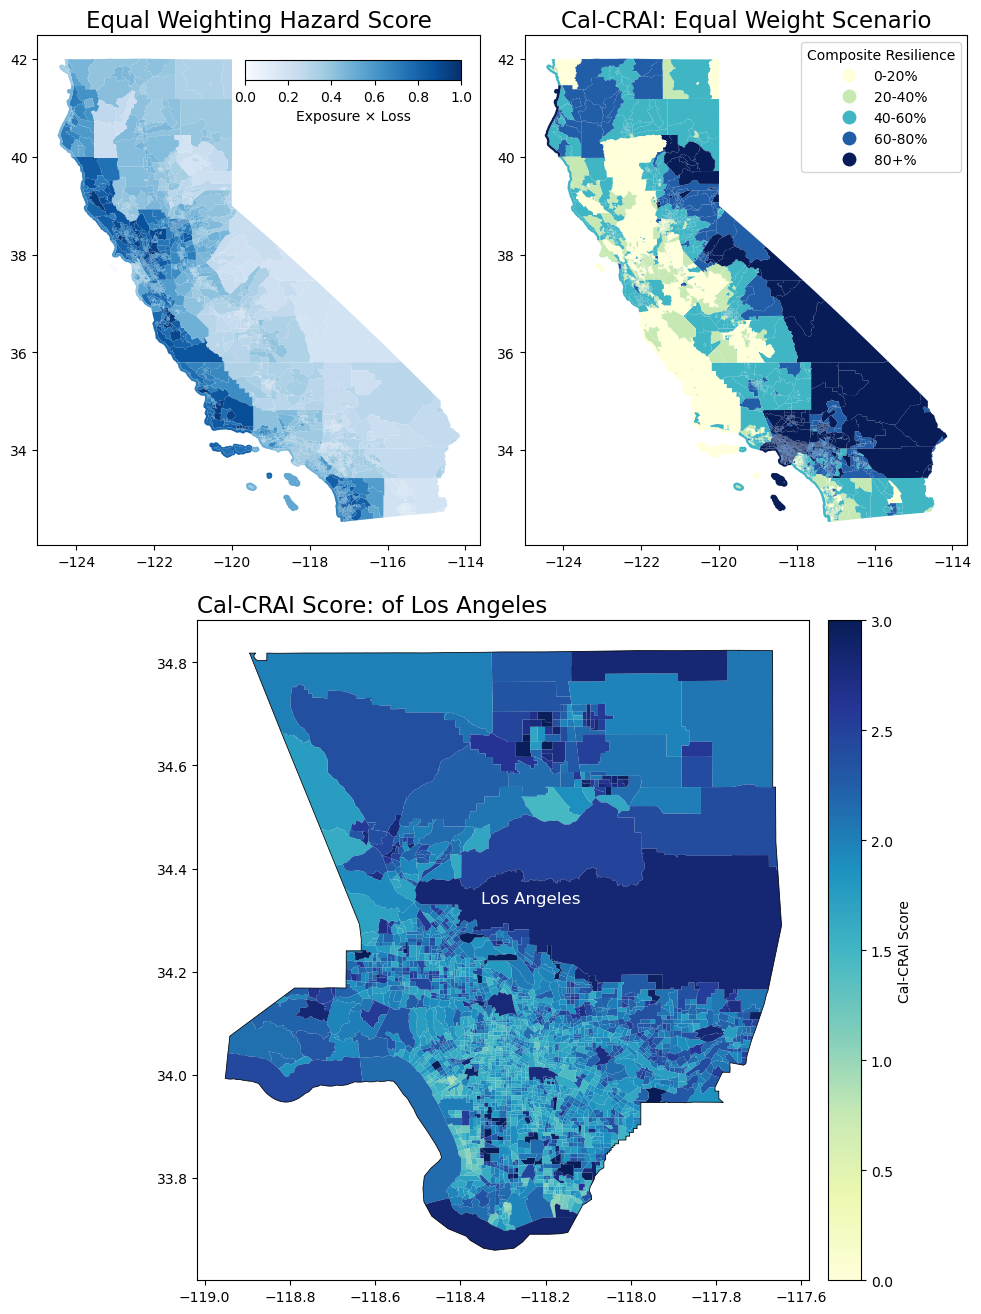

In [209]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Create the figure and GridSpec object
fig = plt.figure(figsize=(12, 20))  # Adjust overall figure size
gs = GridSpec(2, 2, height_ratios=[1, 0.6], wspace=0.1, hspace=-0.25)  # Adjust spacing

# Top-left subplot (hazard score)
ax0 = fig.add_subplot(gs[0, 0])
plot_hazard_score(merged_df, column_to_plot='hazard_score', domain='equal weighting', ax=ax0)

# Top-right subplot (index plot)
ax1 = fig.add_subplot(gs[0, 1])
index_plot(merged_df, 'calcrai_score_quartile', save_name='binned equal weight', 
           scenario='equal weight', plot_title=True, vmin=0, vmax=5, 
           plot_type='discrete', ax=ax1)

# Centered bottom subplot (region domain plot spanning both columns)
ax2 = fig.add_subplot(gs[1, :])  # Use `:` to span across all columns in the bottom row
plot_region_domain(merged_df, counties_to_plot=['037'], region=None, plot_all=False, 
                   savefig=False, font_color='white', domain='', domain_label_map=None, 
                   vmin=0, vmax=3, column_to_plot='calcrai_score', cmap='RdYlBu', 
                   intro_title='Cal-CRAI Score:', 
                   legend_label='Cal-CRAI Score', ax=ax2)

# Save the figure as a PNG file
fig.savefig('CalCRAI_subplot.png', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()
